In [1]:
import copy
from pathlib import Path
import random
from statistics import mean

import numpy as np
import torch
from torch import nn
from tqdm import tqdm

In [2]:
random_seed = 0
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
n_way = 5
n_shot = 5
n_query = 10

DEVICE = "cuda"
n_workers = 12

In [4]:
import os
import json

class_names = [
    'two_up_inverted',
    'dislike',
    'two_up',
    'mute',
    'three2',
    'rock',
    'four',
    'stop',
    'ok',
    'three',
    'stop_inverted',
    'peace',
    'palm',
    'fist',
    'like',
    'one',
    'peace_inverted',
    'call'
]

train_path = '/home/soumik/Code/cropped/train'
val_path = '/home/soumik/Code/cropped/val'
test_path = '/home/soumik/Code/cropped/test'

train_roots = [os.path.join(train_path, class_name) for class_name in class_names]
val_roots = [os.path.join(train_path, class_name) for class_name in class_names]
test_roots = [os.path.join(train_path, class_name) for class_name in class_names]

train_data = {
    "class_names": class_names,
    "class_roots": train_roots
}
val_data = {
    "class_names": class_names,
    "class_roots": val_roots
}
test_data = {
    "class_names": class_names,
    "class_roots": test_roots
}

# Save data to JSON file
json_file = '/home/soumik/Code/cropped/train/classes.json'
with open(json_file, 'w') as f:
    json.dump(train_data, f, indent=4)
print(f"Generated JSON file: {json_file}")

json_file = '/home/soumik/Code/cropped/val/classes.json'
with open(json_file, 'w') as f:
    json.dump(val_data, f, indent=4)
print(f"Generated JSON file: {json_file}")

json_file = '/home/soumik/Code/cropped/test/classes.json'
with open(json_file, 'w') as f:
    json.dump(test_data, f, indent=4)
print(f"Generated JSON file: {json_file}")


Generated JSON file: /home/soumik/Code/cropped/train/classes.json
Generated JSON file: /home/soumik/Code/cropped/val/classes.json
Generated JSON file: /home/soumik/Code/cropped/test/classes.json


In [5]:
#Count number of samples in each class of data folder and print the class names and number of samples
import os
import json

data='/home/soumik/Code/cropped/train/'
data_val='/home/soumik/Code/cropped/val/'
data_test='/home/soumik/Code/cropped/test/'
class_names = os.listdir(data)
class_names.sort()
class_samples = {}
for class_name in class_names:
    try:
        # class_samples[class_name] = len(os.listdir(os.path.join(data, class_name)))
        # class_samples[class_name] = len(os.listdir(os.path.join(data_val, class_name)))
        class_samples[class_name] = len(os.listdir(os.path.join(data_test, class_name)))
    except NotADirectoryError:
        pass

print(json.dumps(class_samples, indent=4))

#Find total samples
total_samples = sum(class_samples.values())
print(f"Total samples: {total_samples}")



{
    "call": 1662,
    "dislike": 1624,
    "fist": 1662,
    "four": 1653,
    "like": 1603,
    "mute": 1664,
    "ok": 1647,
    "one": 1631,
    "palm": 1682,
    "peace": 1643,
    "peace_inverted": 1730,
    "rock": 1643,
    "stop": 1661,
    "stop_inverted": 1682,
    "three": 1648,
    "three2": 1726,
    "two_up": 1694,
    "two_up_inverted": 1694
}
Total samples: 29949


In [6]:
Training: 29593
Validation: 29449
Testing: 29949

In [7]:
from easyfsl.datasets.easy_set import EasySet
from torchvision import transforms

train_set=EasySet('/home/soumik/Code/cropped/train/classes.json',transform=transforms.Compose([transforms.Resize((28,28)),transforms.ToTensor()]))
val_set=EasySet('/home/soumik/Code/cropped/val/classes.json',transform=transforms.Compose([transforms.Resize((28,28)),transforms.ToTensor()]))
test_set=EasySet('/home/soumik/Code/cropped/test/classes.json',transform=transforms.Compose([transforms.Resize((28,28)),transforms.ToTensor()]))

In [8]:
from easyfsl.samplers import TaskSampler
from torch.utils.data import DataLoader

n_tasks_per_epoch = 500
n_validation_tasks = 100

train_sampler = TaskSampler(
    train_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_tasks_per_epoch
)
val_sampler = TaskSampler(
    val_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_validation_tasks
)
test_sampler = TaskSampler(
    test_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_validation_tasks
)

# Finally, the DataLoader. We customize the collate_fn so that batches are delivered
# in the shape: (support_images, support_labels, query_images, query_labels, class_ids)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)
val_loader = DataLoader(
    val_set,
    batch_sampler=val_sampler,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=val_sampler.episodic_collate_fn,
)

n_test_tasks = 1000

test_sampler = TaskSampler(
    test_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_test_tasks
)
test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

In [9]:
from easyfsl.methods import FEAT
from easyfsl.modules import resnet12

few_shot_classifier = FEAT.from_resnet12_checkpoint("/home/soumik/Code/easy-few-shot-learning/pretrained/feat-1-shot.pth",device=DEVICE)

In [10]:
from torch.optim import SGD, Optimizer
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter


LOSS_FUNCTION = nn.CrossEntropyLoss()

n_epochs = 50
scheduler_milestones = [120, 160]
scheduler_gamma = 0.1
learning_rate = 1e-2
tb_logs_dir = Path("../logs/proto")

train_optimizer = SGD(
    few_shot_classifier.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4
)
train_scheduler = MultiStepLR(
    train_optimizer,
    milestones=scheduler_milestones,
    gamma=scheduler_gamma,
)

tb_writer = SummaryWriter(log_dir=str(tb_logs_dir))

2024-08-03 21:36:17.038041: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-03 21:36:17.155306: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-03 21:36:17.200603: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-03 21:36:17.213331: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-03 21:36:17.301551: I tensorflow/core/platform/cpu_feature_guar

In [11]:
from easyfsl.methods import FewShotClassifier

def training_epoch(
    model: FewShotClassifier, data_loader: DataLoader, optimizer: Optimizer
):
    all_loss = []
    model.train()
    with tqdm(
        enumerate(data_loader), total=len(data_loader), desc="Training"
    ) as tqdm_train:
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            _,
        ) in tqdm_train:
            optimizer.zero_grad()
            model.process_support_set(
                support_images.to(DEVICE), support_labels.to(DEVICE)
            )
            classification_scores = model(query_images.to(DEVICE))

            loss = LOSS_FUNCTION(classification_scores, query_labels.to(DEVICE))
            loss.backward()
            optimizer.step()

            all_loss.append(loss.item())

            tqdm_train.set_postfix(loss=mean(all_loss))

    return mean(all_loss)

In [12]:
from easyfsl.utils import evaluate

train_losses=[]
validation_accuracies=[]
best_state = few_shot_classifier.state_dict()
best_validation_accuracy = 0.0
model_save_path="/home/soumik/Code/easy-few-shot-learning/savedmodels/feat.pth"
for epoch in range(n_epochs):
    print(f"Epoch {epoch}")
    average_loss = training_epoch(few_shot_classifier, train_loader, train_optimizer)
    train_losses.append(average_loss)
    
    validation_accuracy = evaluate(
        few_shot_classifier, val_loader, device=DEVICE, tqdm_prefix="Validation"
    )
    validation_accuracies.append(validation_accuracy)

    if validation_accuracy > best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        best_state = copy.deepcopy(few_shot_classifier.state_dict())
        # state_dict() returns a reference to the still evolving model's state so we deepcopy
        # https://pytorch.org/tutorials/beginner/saving_loading_models
        torch.save(best_state, model_save_path)
        print("Ding ding ding! We found a new best model!")

    tb_writer.add_scalar("Train/loss", average_loss, epoch)
    tb_writer.add_scalar("Val/acc", validation_accuracy, epoch)

    # Warn the scheduler that we did an epoch
    # so it knows when to decrease the learning rate
    train_scheduler.step()

Epoch 0


Validation: 100%|██████████| 100/100 [00:01<00:00, 58.61it/s, accuracy=0.985]


Ding ding ding! We found a new best model!
Epoch 1


Validation: 100%|██████████| 100/100 [00:01<00:00, 62.43it/s, accuracy=0.989]


Ding ding ding! We found a new best model!
Epoch 2


Validation: 100%|██████████| 100/100 [00:01<00:00, 67.05it/s, accuracy=0.994]


Ding ding ding! We found a new best model!
Epoch 3


Validation: 100%|██████████| 100/100 [00:01<00:00, 60.20it/s, accuracy=0.996]


Ding ding ding! We found a new best model!
Epoch 4


Validation: 100%|██████████| 100/100 [00:01<00:00, 63.60it/s, accuracy=0.998]


Ding ding ding! We found a new best model!
Epoch 5


Validation: 100%|██████████| 100/100 [00:01<00:00, 62.47it/s, accuracy=0.996]

Epoch 6



Validation: 100%|██████████| 100/100 [00:01<00:00, 53.31it/s, accuracy=0.997]

Epoch 7



Validation: 100%|██████████| 100/100 [00:01<00:00, 61.55it/s, accuracy=0.997]

Epoch 8



Validation: 100%|██████████| 100/100 [00:01<00:00, 63.05it/s, accuracy=0.997]

Epoch 9



Validation: 100%|██████████| 100/100 [00:01<00:00, 61.19it/s, accuracy=0.998]

Epoch 10



Validation: 100%|██████████| 100/100 [00:01<00:00, 57.05it/s, accuracy=0.997]

Epoch 11



Validation: 100%|██████████| 100/100 [00:01<00:00, 56.01it/s, accuracy=0.997]

Epoch 12



Validation: 100%|██████████| 100/100 [00:01<00:00, 60.83it/s, accuracy=0.999]


Ding ding ding! We found a new best model!
Epoch 13


Validation: 100%|██████████| 100/100 [00:01<00:00, 54.57it/s, accuracy=0.998]

Epoch 14



Validation: 100%|██████████| 100/100 [00:01<00:00, 62.58it/s, accuracy=0.999]

Epoch 15



Validation: 100%|██████████| 100/100 [00:01<00:00, 57.50it/s, accuracy=0.999]


Ding ding ding! We found a new best model!
Epoch 16


Validation: 100%|██████████| 100/100 [00:01<00:00, 57.57it/s, accuracy=0.999]


Ding ding ding! We found a new best model!
Epoch 17


Validation: 100%|██████████| 100/100 [00:01<00:00, 57.51it/s, accuracy=0.999]

Epoch 18



Validation: 100%|██████████| 100/100 [00:01<00:00, 65.76it/s, accuracy=1]   


Ding ding ding! We found a new best model!
Epoch 19


Validation: 100%|██████████| 100/100 [00:01<00:00, 57.30it/s, accuracy=0.999]

Epoch 20



Validation: 100%|██████████| 100/100 [00:01<00:00, 56.39it/s, accuracy=1]


Ding ding ding! We found a new best model!
Epoch 21


Validation: 100%|██████████| 100/100 [00:01<00:00, 64.00it/s, accuracy=0.999]

Epoch 22



Validation: 100%|██████████| 100/100 [00:01<00:00, 59.77it/s, accuracy=0.999]


Epoch 23


Validation: 100%|██████████| 100/100 [00:01<00:00, 62.83it/s, accuracy=0.999]

Epoch 24



Validation: 100%|██████████| 100/100 [00:01<00:00, 59.01it/s, accuracy=1]   

Epoch 25



Validation: 100%|██████████| 100/100 [00:01<00:00, 62.44it/s, accuracy=0.999]

Epoch 26



Validation: 100%|██████████| 100/100 [00:01<00:00, 56.67it/s, accuracy=0.997]

Epoch 27



Validation: 100%|██████████| 100/100 [00:01<00:00, 63.07it/s, accuracy=1]   

Epoch 28



Validation: 100%|██████████| 100/100 [00:01<00:00, 62.19it/s, accuracy=0.999]

Epoch 29



Validation: 100%|██████████| 100/100 [00:01<00:00, 58.53it/s, accuracy=0.998]

Epoch 30



Validation: 100%|██████████| 100/100 [00:01<00:00, 62.48it/s, accuracy=0.999]

Epoch 31



Validation: 100%|██████████| 100/100 [00:01<00:00, 65.81it/s, accuracy=0.999]

Epoch 32



Validation: 100%|██████████| 100/100 [00:01<00:00, 65.78it/s, accuracy=0.999]

Epoch 33



Validation: 100%|██████████| 100/100 [00:01<00:00, 58.57it/s, accuracy=1]

Epoch 34



Validation: 100%|██████████| 100/100 [00:01<00:00, 63.49it/s, accuracy=0.999]


Epoch 35


Validation: 100%|██████████| 100/100 [00:01<00:00, 62.45it/s, accuracy=0.999]

Epoch 36



Validation: 100%|██████████| 100/100 [00:01<00:00, 61.61it/s, accuracy=0.999]

Epoch 37



Validation: 100%|██████████| 100/100 [00:01<00:00, 57.26it/s, accuracy=1]

Epoch 38



Validation: 100%|██████████| 100/100 [00:01<00:00, 61.73it/s, accuracy=0.999]

Epoch 39



Validation: 100%|██████████| 100/100 [00:01<00:00, 53.92it/s, accuracy=1]

Epoch 40



Validation: 100%|██████████| 100/100 [00:01<00:00, 55.15it/s, accuracy=1]   

Epoch 41



Validation: 100%|██████████| 100/100 [00:01<00:00, 61.69it/s, accuracy=0.999]


Epoch 42


Validation: 100%|██████████| 100/100 [00:01<00:00, 55.72it/s, accuracy=0.999]

Epoch 43



Validation: 100%|██████████| 100/100 [00:01<00:00, 57.38it/s, accuracy=0.996]

Epoch 44



Validation: 100%|██████████| 100/100 [00:01<00:00, 56.55it/s, accuracy=0.998]


Epoch 45


Validation: 100%|██████████| 100/100 [00:01<00:00, 61.00it/s, accuracy=0.997]

Epoch 46



Validation: 100%|██████████| 100/100 [00:01<00:00, 62.72it/s, accuracy=0.999]

Epoch 47



Validation: 100%|██████████| 100/100 [00:01<00:00, 54.79it/s, accuracy=0.995]

Epoch 48



Validation: 100%|██████████| 100/100 [00:01<00:00, 58.27it/s, accuracy=0.996]

Epoch 49



Validation: 100%|██████████| 100/100 [00:01<00:00, 58.98it/s, accuracy=0.999]


In [13]:
accuracy = evaluate(few_shot_classifier, test_loader, device=DEVICE)
print(f"Average accuracy : {(100 * accuracy):.2f} %")

100%|██████████| 1000/1000 [00:14<00:00, 68.91it/s, accuracy=0.999]

Average accuracy : 99.94 %


In [14]:
model_save_path="/home/soumik/Code/easy-few-shot-learning/savedmodels/feat.pth"
few_shot_classifier.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

In [15]:

import torchvision.transforms as tt
import torch
from torchvision.datasets import ImageFolder
from easyfsl.methods import FewShotClassifier
from torch.utils.data import DataLoader
import PIL

class FewShotPredictor :
    """

        This class aims to implement a predictor for a Few-shot classifier.

        The few shot classifiers need a support set that will be used for calculating the distance between the support set and the query image.

        To load the support we have used an ImageFolder Dataset, which needs to have the following structure:

        folder:
          |_ class_name_folder_1:
                 |_ image_1
                 |_  …
                 |_ image_n
          |_ class_name_folder_2:
                 |_ image_1
                 |_  …
                 |_ image_n

        The folder must contain the same number of images per class, being the total images (n_way * n_shot).

        There must be n_way folders with n_shot images per folder.

    """

    def __init__(self ,
                 classifier: FewShotClassifier,
                 device,
                 path_to_support_images,
                 n_way,
                 n_shot,
                 input_size=28):

        """
            :param classifier: created and loaded model
            :param device: device to be executed
            :param path_to_support_images: path to creating a support set
            :param n_way: number of classes
            :param n_shot: number of images on each class
            :param input_size: size of image

        """
        self.classifier = classifier
        self.device = device

        self.predict_transformation = tt.Compose([
            tt.Resize((input_size, input_size)),
            tt.ToTensor()
        ])

        self.test_ds = ImageFolder(path_to_support_images, self.predict_transformation)

        self.val_loader = DataLoader(
            self.test_ds,
            batch_size= (n_way*n_shot),
            num_workers=1,
            pin_memory=True
        )

        self.support_images, self.support_labels = next(iter(self.val_loader))



    def predict (self, tensor_normalized_image):
        """

        :param tensor_normalized_image:
        Example of normalized image:

            pil_img = PIL.Image.open(img_dir)

            torch_img = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor()
            ])(pil_img)

            tensor_normalized_image = tt.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]


        :return:

        Return

        predict = tensor with prediction (mean distance of query image and support set)
        torch_max [1] = predicted class index

        """



        with torch.no_grad():
           self.classifier.eval()
           self.classifier.to(self.device)
           self.classifier.process_support_set(self.support_images.to(self.device), self.support_labels.to(self.device))
           pre_predict = self.classifier(tensor_normalized_image.to(self.device))
           predict = pre_predict.detach().data
           torch_max = torch.max(predict,1)
           class_name = self.test_ds.classes[torch_max[1].item()]
           return predict, torch_max[1], class_name


In [16]:
from torchvision import transforms
from PIL import Image

# Define the transformation for the input image
preprocess = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Initialize the FewShotPredictor
predictor = FewShotPredictor(few_shot_classifier, DEVICE, "/home/soumik/Code/easy-few-shot-learning/support", 3, 5, 28)

pil_img = PIL.Image.open("/home/soumik/Code/easy-few-shot-learning/support/2/00a4406e-d2bd-4110-8855-4e0d659b729b.jpg")

torch_img = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor()
    ])(pil_img)

tensor_normalized_image = tt.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]
FewShotPredictor(few_shot_classifier,DEVICE,"/home/soumik/Code/easy-few-shot-learning/support",3,5,28).predict(tensor_normalized_image)

(tensor([[-20.0112,  -9.7762, -22.2944]], device='cuda:0'),
 tensor([1], device='cuda:0'),
 '2')

In [17]:
import cv2
import torch
from torchvision import transforms
from PIL import Image

# Define the transformation for the input image
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def predict_frame(frame, predictor):
    # Convert the frame to a PIL image
    pil_img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    
    # Preprocess the image
    torch_img = preprocess(pil_img).unsqueeze(0)  # Add batch dimension

    # Move the image tensor to the device
    tensor_normalized_image = torch_img.to(DEVICE)
    
    # Predict using the FewShotPredictor
    prediction = predictor.predict(tensor_normalized_image)
    
    return prediction

# Initialize the video capture
cap = cv2.VideoCapture(0)

# Initialize the FewShotPredictor
predictor = FewShotPredictor(few_shot_classifier, DEVICE, "/home/soumik/Code/easy-few-shot-learning/support", 3, 5, 28)

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    if not ret:
        break
    
    # Predict the frame
    prediction = predict_frame(frame, predictor)

    # Display the resulting frame
    cv2.putText(frame, f'Prediction: {prediction}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.imshow('Frame', frame)

    # Break the loop on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
# cv2.destroyAllWindows()


[ WARN:0@10.072] global cap_v4l.cpp:1136 tryIoctl VIDEOIO(V4L2:/dev/video0): select() timeout.


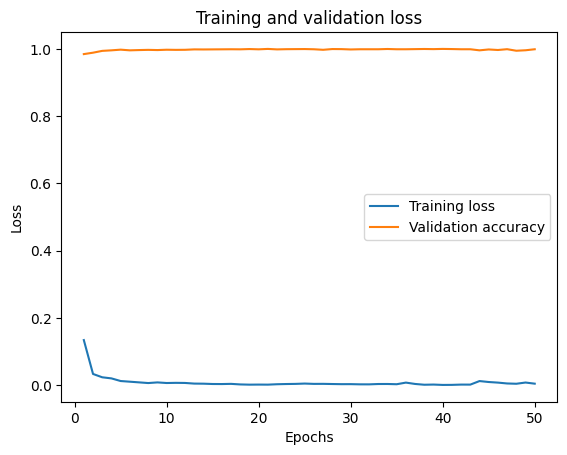

In [18]:
#Plot loss and accuracy of a model using loss array and val_loss array
import matplotlib.pyplot as plt

# I got a list of losses and valacccuracies from the training process
loss = train_losses
val_loss = validation_accuracies

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation accuracy')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
